Random Forest Classifier Training

In [14]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, 
                            n_iter=20, cv=3, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)
print("Best Accuracy:", search.best_score_)
print("Best Parameters:", search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Accuracy: 0.5814814814814815
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30, 'bootstrap': True}


Training:  47%|████▋     | 943/2000 [14:18<16:02,  1.10it/s]


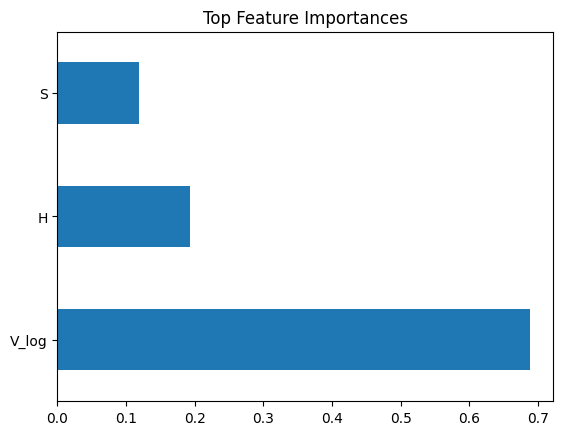

In [16]:
import matplotlib.pyplot as plt

feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.nlargest(20).plot(kind='barh')
plt.title("Top Feature Importances")
plt.show()


In [17]:
X_train_selected = X_train[['V_log', 'H']]
X_test_selected = X_test[['V_log', 'H']]

model = RandomForestClassifier(**search.best_params_, random_state=42)
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.42      0.45      0.43        11
           1       0.85      0.92      0.88        12
           2       0.40      0.38      0.39        16
           3       0.18      0.27      0.21        11
           4       0.36      0.22      0.28        18

    accuracy                           0.43        68
   macro avg       0.44      0.45      0.44        68
weighted avg       0.44      0.43      0.42        68



In [21]:
import pandas as pd
import time
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm.auto import tqdm

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting target as M - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier with the specified parameters
model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=None,
    max_depth=30,
    bootstrap=True,
    random_state=42
)

# Train the model
start_time = time.time()
model.fit(X_train, y_train)

end_time = time.time()

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ RandomForest Accuracy: {accuracy:.4f}")
print(f"🕒 Training Time: {end_time - start_time:.2f} seconds")
print(classification_report(y_test, y_pred))

# Save the trained model to a file
joblib.dump(model, "randomforest_model.pkl")


✅ RandomForest Accuracy: 0.5588
🕒 Training Time: 0.10 seconds
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.92      0.92      0.92        12
           2       0.62      0.50      0.55        16
           3       0.28      0.45      0.34        11
           4       0.50      0.39      0.44        18

    accuracy                           0.56        68
   macro avg       0.59      0.58      0.58        68
weighted avg       0.59      0.56      0.57        68



['randomforest_model.pkl']

In [1]:
import pandas as pd
import time
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting target as M - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function to optimize hyperparameters
def objective(trial):
    # Suggest hyperparameters using optuna
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    # Removing 'auto' and allowing only valid options for max_features
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Initialize the RandomForest model with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study to maximize accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)  # You can adjust n_trials for more trials

# Output the best hyperparameters and best accuracy
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Accuracy: {study.best_value:.4f}")

# Train the final model using the best hyperparameters
best_params = study.best_params
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Final RandomForest Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Save the final model
joblib.dump(final_model, "best_randomforest_model_optuna.pkl")


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-13 07:25:20,760] A new study created in memory with name: no-name-8e32dea8-68d7-4739-80ec-14586ea6a0dc
[I 2025-04-13 07:25:20,963] Trial 0 finished with value: 0.39705882352941174 and parameters: {'n_estimators': 282, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.39705882352941174.
[I 2025-04-13 07:25:21,347] Trial 1 finished with value: 0.5441176470588235 and parameters: {'n_estimators': 422, 'max_depth': 34, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.5441176470588235.
[I 2025-04-13 07:25:21,529] Trial 2 finished with value: 0.4411764705882353

Best Hyperparameters: {'n_estimators': 86, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}
Best Accuracy: 0.6029
✅ Final RandomForest Accuracy: 0.6029
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.58        11
           1       1.00      0.92      0.96        12
           2       0.69      0.56      0.62        16
           3       0.35      0.55      0.43        11
           4       0.57      0.44      0.50        18

    accuracy                           0.60        68
   macro avg       0.63      0.62      0.62        68
weighted avg       0.63      0.60      0.61        68



['best_randomforest_model_optuna.pkl']

XGBoost Model

In [8]:
import pandas as pd
import time
import joblib
import optuna
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting target as M - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function to optimize hyperparameters
def objective(trial):
    # Suggest hyperparameters using optuna
    n_estimators = trial.suggest_int("n_estimators", 75, 500)
    max_depth = trial.suggest_int("max_depth", 4, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.3)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_float("gamma", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.3, 1.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    # Initialize the XGBoost model with suggested hyperparameters
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        gamma=gamma,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        random_state=42
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study to maximize accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)  # You can adjust n_trials for more trials

# Output the best hyperparameters and best accuracy
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Accuracy: {study.best_value:.4f}")

# Train the final model using the best hyperparameters
best_params = study.best_params
final_model = XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Final XGBoost Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Save the final model
joblib.dump(final_model, "best_xgboost_model_optuna.pkl")


[I 2025-04-13 07:33:27,274] A new study created in memory with name: no-name-b357ad06-315e-4d7f-8273-251b7e001e39
[I 2025-04-13 07:33:27,427] Trial 0 finished with value: 0.4117647058823529 and parameters: {'n_estimators': 485, 'max_depth': 10, 'learning_rate': 0.2732615008010978, 'min_child_weight': 8, 'gamma': 0.42789863834553776, 'colsample_bytree': 0.41655048631047076, 'subsample': 0.503749879952039}. Best is trial 0 with value: 0.4117647058823529.
[I 2025-04-13 07:33:27,619] Trial 1 finished with value: 0.4264705882352941 and parameters: {'n_estimators': 341, 'max_depth': 6, 'learning_rate': 0.1267424631613009, 'min_child_weight': 1, 'gamma': 0.04256904419194141, 'colsample_bytree': 0.39202379351357525, 'subsample': 0.8566195244330396}. Best is trial 1 with value: 0.4264705882352941.
[I 2025-04-13 07:33:27,744] Trial 2 finished with value: 0.4852941176470588 and parameters: {'n_estimators': 320, 'max_depth': 5, 'learning_rate': 0.06200442600170235, 'min_child_weight': 7, 'gamma': 

Best Hyperparameters: {'n_estimators': 248, 'max_depth': 7, 'learning_rate': 0.20710492020026877, 'min_child_weight': 8, 'gamma': 0.0682962176965653, 'colsample_bytree': 0.8501795982926942, 'subsample': 0.7640401717696358}
Best Accuracy: 0.6029
✅ Final XGBoost Accuracy: 0.6029
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.79      0.92      0.85        12
           2       0.59      0.62      0.61        16
           3       0.38      0.45      0.42        11
           4       0.50      0.33      0.40        18

    accuracy                           0.60        68
   macro avg       0.60      0.63      0.61        68
weighted avg       0.59      0.60      0.59        68



['best_xgboost_model_optuna.pkl']

Gradient Boosting

In [1]:
import pandas as pd
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20)
    }

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(**params, random_state=42))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best model
print("✅ Best Accuracy:", study.best_value)
print("📊 Best Hyperparameters:", study.best_params)

# Train best model
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(**study.best_params, random_state=42))
])
best_model.fit(X_train, y_train)

# Final evaluation
y_pred = best_model.predict(X_test)
print(f"\n🎯 Final Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(best_model, "gradientboosting_model_optuna.pkl")


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-14 17:15:30,352] A new study created in memory with name: no-name-e3c238de-315b-4964-8598-1bd9bd536552
[I 2025-04-14 17:15:40,728] Trial 0 finished with value: 0.6029411764705882 and parameters: {'n_estimators': 2030, 'learning_rate': 0.0034292714622412646, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.6029411764705882.
[I 2025-04-14 17:15:44,320] Trial 1 finished with value: 0.5588235294117647 and parameters: {'n_estimators': 982, 'learning_rate': 0.0075593043941482516, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.6029411764705882.
[I 2025-04-14 17:15:51,642] Trial 2 finished with value: 0.5 and parameters: {'n

✅ Best Accuracy: 0.6176470588235294
📊 Best Hyperparameters: {'n_estimators': 2464, 'learning_rate': 0.10416790551323693, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 16}

🎯 Final Accuracy: 0.6176
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.92      0.92      0.92        12
           2       0.62      0.62      0.62        16
           3       0.33      0.55      0.41        11
           4       0.58      0.39      0.47        18

    accuracy                           0.62        68
   macro avg       0.65      0.64      0.64        68
weighted avg       0.65      0.62      0.62        68



['gradientboosting_model_optuna.pkl']


🧾 Confusion Matrix:
[[ 8  0  1  1  1]
 [ 0 11  0  1  0]
 [ 1  0 10  4  1]
 [ 0  1  1  6  3]
 [ 1  0  4  6  7]]


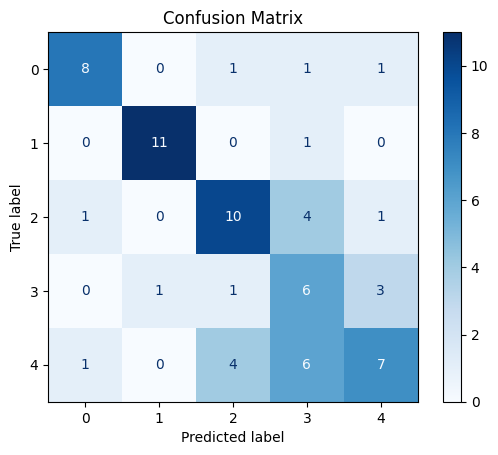

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🧾 Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


MLP Classifer

In [ ]:
import pandas as pd
import joblib
import optuna
import time

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare features and labels
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Target adjustment

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional train-test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Objective function for Optuna
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [(64,), (128,), (64, 64), (128, 64), (128, 128)])
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 200, 800)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=42
    )

    # Use cross-validation
    accuracy = cross_val_score(clf, X_scaled, y, cv=5, scoring="accuracy").mean()
    return accuracy

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Output best result
print(f"🔧 Best Hyperparameters:\n{study.best_params}")
print(f"🏆 Best CV Accuracy: {study.best_value:.4f}")

# Train final model with best params
best_params = study.best_params
final_model = MLPClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Final MLP Accuracy: {accuracy:.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save model and scaler
joblib.dump(final_model, "best_mlp_model_optuna.pkl")
joblib.dump(scaler, "mlp_scaler.pkl")


[I 2025-04-14 18:32:52,796] A new study created in memory with name: no-name-d8616d44-0425-4ccf-be15-f031dc5f48d1
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128,) which is of type tuple.
  warnings.warn(message)
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 64) which is of type tuple.
  warnings.warn(message)
/teamspace/studios

🔧 Best Hyperparameters:
{'hidden_layer_sizes': (64, 64), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0009747463996145735, 'learning_rate_init': 0.0018593430004181788, 'max_iter': 676}
🏆 Best CV Accuracy: 0.7661

✅ Final MLP Accuracy: 0.5882

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.86      1.00      0.92        12
           2       0.42      0.31      0.36        16
           3       0.46      0.55      0.50        11
           4       0.47      0.39      0.42        18

    accuracy                           0.59        68
   macro avg       0.58      0.63      0.60        68
weighted avg       0.56      0.59      0.57        68



/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (676) reached and the optimization hasn't converged yet.
  warnings.warn(


['mlp_scaler.pkl']

MLPClassifier Model(with higher accuracy)

In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare features and labels
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusted target labels

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)



# Use best hyperparameters from Optuna study
best_params = {
    'hidden_layer_sizes': (64, 64),
    'activation': 'tanh',
    'solver': 'adam',
    'alpha': 0.0009747463996145735,
    'learning_rate_init': 0.0018593430004181788,
    'max_iter': 676
}

# Initialize and train the MLP model
mlp_model = MLPClassifier(**best_params, random_state=42)
mlp_model.fit(X_train, y_train)

# Predict and evaluate on test data
y_pred = mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Final MLP Accuracy: {accuracy:.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save the final model and scaler
joblib.dump(mlp_model, "final_mlp_model.pkl")
joblib.dump(scaler, "mlp_scaler.pkl")


✅ Final MLP Accuracy: 0.7500

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.93      1.00      0.97        14
           2       0.67      0.62      0.64        13
           3       0.82      0.69      0.75        13
           4       0.50      0.46      0.48        13

    accuracy                           0.75        68
   macro avg       0.74      0.74      0.74        68
weighted avg       0.74      0.75      0.74        68



/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (676) reached and the optimization hasn't converged yet.
  warnings.warn(


['mlp_scaler.pkl']

In [2]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Final MLP model with best Optuna hyperparameters
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 128, 64),
    activation="relu",
    solver="adam",
    alpha=0.00022155272099481024,
    learning_rate_init=0.038373306648018864,
    max_iter=645,
    random_state=42
)

# Train the model
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

# Evaluation
print(f"✅ Final MLP Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save model and scaler
joblib.dump(mlp, "mlp_final_optuna_relu.pkl")
joblib.dump(scaler, "scaler_final_optuna_relu.pkl")


✅ Final MLP Accuracy: 0.7500

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       1.00      1.00      1.00        14
           2       0.62      0.77      0.69        13
           3       0.83      0.77      0.80        13
           4       0.42      0.38      0.40        13

    accuracy                           0.75        68
   macro avg       0.75      0.74      0.74        68
weighted avg       0.75      0.75      0.75        68



['scaler_final_optuna_relu.pkl']

[I 2025-04-15 18:00:53,283] A new study created in memory with name: no-name-61c7a29c-e1f0-4eba-80e1-1098d0ec3727
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 128) which is of type tuple.
  warnings.warn(message)
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)
[I 2025-04-1

🔧 Best Hyperparameters:
{'hidden_layer_sizes': (256, 128), 'alpha': 1.5533844813198423e-05, 'learning_rate_init': 0.012213599390700235, 'max_iter': 587}
🏆 Best Accuracy: 0.7941


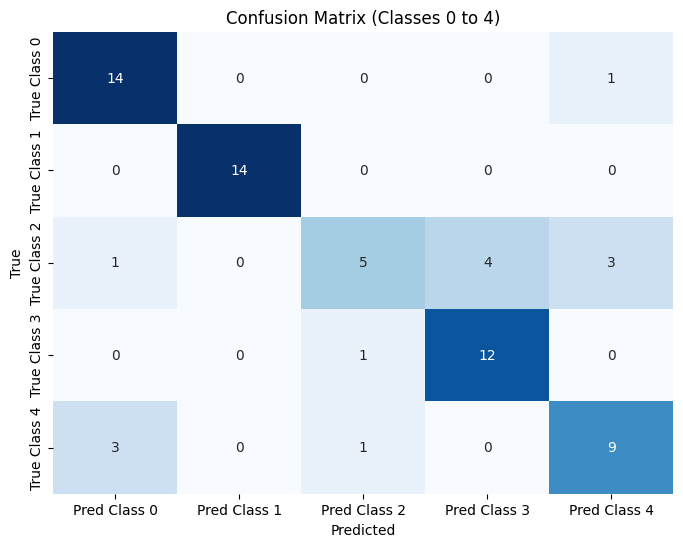


✅ Final MLP Accuracy: 0.7941

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       1.00      1.00      1.00        14
           2       0.71      0.38      0.50        13
           3       0.75      0.92      0.83        13
           4       0.69      0.69      0.69        13

    accuracy                           0.79        68
   macro avg       0.79      0.79      0.77        68
weighted avg       0.79      0.79      0.78        68



['scaler_optuna_best_relu.pkl']

In [6]:
import pandas as pd
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Optuna objective function with pruning
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(128, 128), (256, 128), (256, 128), (256, 128, 64), (256, 128, 64)]
    )
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 2e-4, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 300, 800)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation="relu",
        solver="adam",
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Report intermediate accuracy and prune if necessary
    trial.report(accuracy, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return accuracy

# Run Optuna study with pruning
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, timeout=600)  # Add timeout or other limits if needed

# Print best params
print("🔧 Best Hyperparameters:")
print(study.best_params)
print(f"🏆 Best Accuracy: {study.best_value:.4f}")

# Train final model
best_params = study.best_params
final_model = MLPClassifier(
    **best_params,
    activation="relu",
    solver="adam",
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn for classes 0 to 4
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=[f'Pred Class {i}' for i in range(5)], 
            yticklabels=[f'True Class {i}' for i in range(5)])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Classes 0 to 4)')
plt.show()

print(f"\n✅ Final MLP Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save model and scaler
joblib.dump(final_model, "mlp_optuna_best_relu.pkl")
joblib.dump(scaler, "scaler_optuna_best_relu.pkl")


✅ Final MLP Accuracy: 0.7941

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       1.00      1.00      1.00        14
           2       0.71      0.38      0.50        13
           3       0.75      0.92      0.83        13
           4       0.69      0.69      0.69        13

    accuracy                           0.79        68
   macro avg       0.79      0.79      0.77        68
weighted avg       0.79      0.79      0.78        68



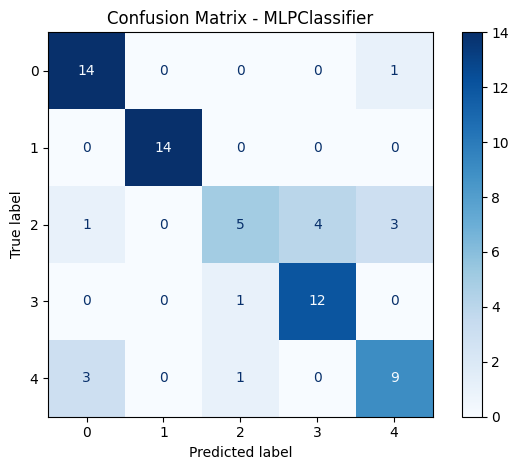

['scaler_optuna_best_relu.pkl']

In [8]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare features and labels
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Shift labels from 1–5 to 0–4

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Define and train the final MLP model
clf = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    alpha=1.5533844813198423e-05,
    learning_rate_init=0.012213599390700235,
    max_iter=587,
    activation="relu",
    solver="adam",
    random_state=42
)

clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Final MLP Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=[0, 1, 2, 3, 4], cmap="Blues"
)
plt.title("Confusion Matrix - MLPClassifier")
plt.tight_layout()
plt.show()

# Save model and scaler
joblib.dump(clf, "mlp_optuna_best_relu.pkl")
joblib.dump(scaler, "scaler_optuna_best_relu.pkl")
